In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np, yaml, cPickle as pickle
import data_io
import pandas as pd
from copy import copy
from sklearn.cross_validation import train_test_split

golden = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in richness labels and spectrograms and biotic predictions

In [24]:
richness = pd.read_csv(
    data_io.large_base + '../diversity_labelled_data/resultAndSiteFiles/6SitesWith90Minutes.csv')

richness_files = set(xx.split('.')[0] for xx in richness.File)

fname_to_richness = {}
for idx, row in richness.iterrows():
    
    fname_to_richness[row['File'].split('.')[0]] = sum(
        yy for xx, yy in row.iteritems() if xx != u'File')

In [25]:
# load in the spectrograms as computed
specs = {}
for fname in richness_files:
    specs[fname] = pickle.load(open('tmp/specs/' + fname +  '.pkl'))

In [26]:
# load in the predictions
preds = {}
for fname in richness_files:
    preds[fname] = pickle.load(open('tmp/preds/' + fname +  '_biotic.pkl'))

## Train test split by *site*

In [27]:
sites = list(set(xx.split('_')[0] for xx in richness_files))
test_sites = sites[0:1]
train_sites = sites[1:]

In [28]:
test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

## Compute features from spectrograms

In [29]:
from features import compute_all_feats

test_X = compute_all_feats(specs, test_files, preds)
train_X = compute_all_feats(specs, train_files, preds)

test_y = np.hstack(fname_to_richness[fname] for fname in test_files)
train_y = np.hstack(fname_to_richness[fname] for fname in train_files)

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(449, 33) (449,) (89, 33) (89,)


## Do machine learning

In [30]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(25, max_depth=25)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

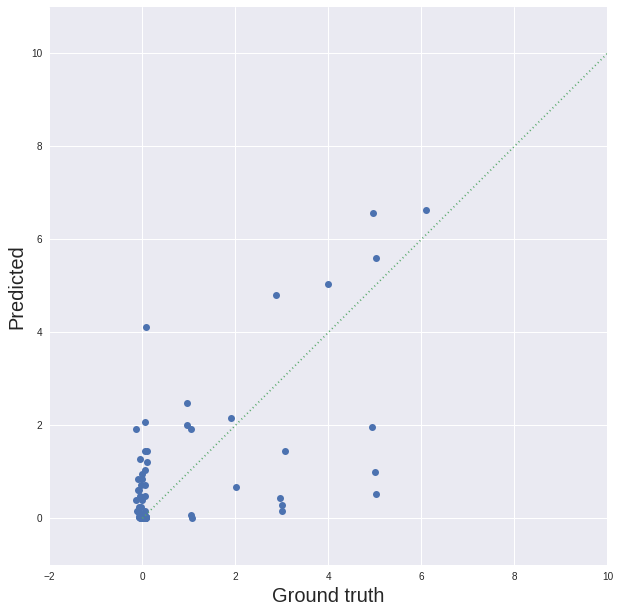

In [31]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plt.plot(test_y + np.random.randn(test_y.shape[0]) * 0.05 , pred_y, 'o')
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')

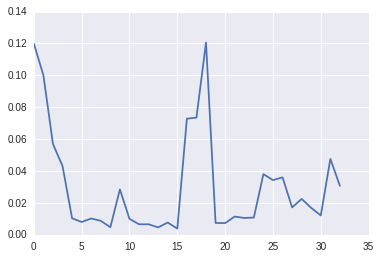

In [32]:
plt.plot(rf.feature_importances_)

## Do it again, but this time do for all sites

In [56]:
print np.bincount(train_y)

[342  46  27  19   4   9   2]


In [66]:
print idxs


[ True  True  True ..., False False False]


In [69]:
all_preds = []
all_gt = []

for test_site in sites:
    test_sites = [test_site]
    train_sites = list(set(sites) - set(test_sites))

    test_files = [xx for xx in richness_files if xx.split('_')[0] in test_sites]
    train_files = [xx for xx in richness_files if xx.split('_')[0] in train_sites]

    # Compute features
    test_X = compute_all_feats(specs, test_files, preds)
    train_X = compute_all_feats(specs, train_files, preds)

    test_y = np.hstack(fname_to_richness[fname] for fname in test_files)
    train_y = np.hstack(fname_to_richness[fname] for fname in train_files)
    
    # Resample training classes
    if 1:
        max_cls_size = np.bincount(train_y).max()
        idxs = []
        for cls in np.unique(train_y):
            idxs.append(np.random.choice(np.where(train_y == cls)[0], max_cls_size))
        idxs = np.hstack(idxs)
        train_X = train_X[idxs]
        train_y = train_y[idxs]

    # Training and prediction
    rf = RandomForestRegressor(10, max_depth=15)
    rf.fit(train_X, train_y)
    pred_y = rf.predict(test_X)
    
    all_preds.append(pred_y)
    all_gt.append(test_y)
    

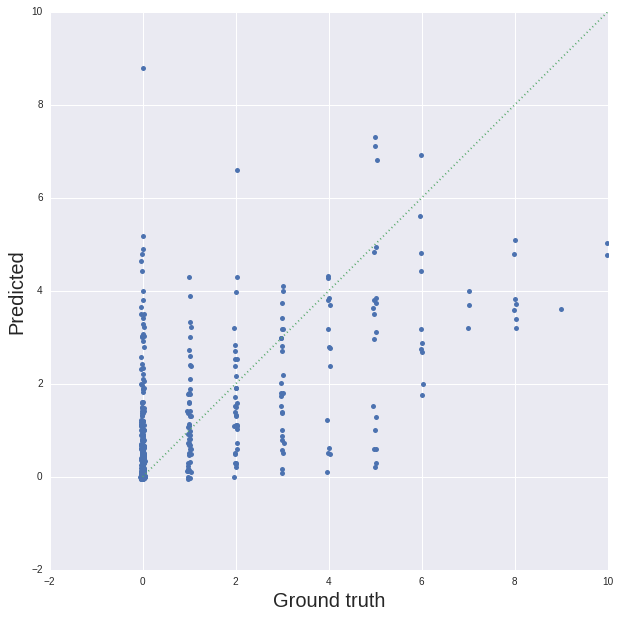

In [73]:
# plot for all
all_preds = np.hstack(all_preds)
all_gt = np.hstack(all_gt)

plt.figure(figsize=(10, 10))
plt.plot(all_gt + np.random.randn(all_gt.shape[0]) * 0.02 , 
         all_preds + np.random.randn(all_gt.shape[0]) * 0.02, 
         'o', markersize=5)
plt.xlabel('Ground truth', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')
